# <font color='0066CC'>**Machine Learning and Pattern Recognition CO2 Project Work**</font>
## <font color='0066CC'>**Sepsis Mars Endotype and Survival Prediction through Gene Expression**</font>
##### Participants: Daniela Charraga Garcia, Flavia D'Eramo, Jolafin Hostettler

### <font color='0077AA'>**Project Overview and Research Question**</font>

Sepsis is a life-threatening condition where the body’s response to infection becomes dysregulated. A key challenge is that two patients with sepsis can look similar clinically but have very different underlying immune responses and outcomes.

In their paper, Scicluna et. al. used whole-blood transcriptomic profiles from ICU patients with sepsis to address the heterogeneity that exists when diagnosing sepsis. They applied unsupervised learning to the gene expression data to identify four molecular endotypes (Mars1–Mars4). The aim was to discover data-driven subgroups that reflect different host-response patterns and that could help with risk stratification and therefore more tailored treatment decisions. In the paper, these endotypes were linked to clinical traits and differences in mortality risk.

In this project, we “work backwards” from that idea using a supervised learning approach and ask: "Using the published Mars endotypes (Mars1-4, Scicluna et. al.), can we train supervised models based on whole-blood transcriptomic  data to reproduce the Mars endotype classification, and do these predictions still stratify 28-day mortality risk reported in the original study?". 

To address this, the project is divided into two objectives: 
1) Supervised reproduction of Mars endotypes using gene-expression features only
2) Assessment of whether predicted endotypes preserve the mortality risk gradient reported in the original study

### <font color='0077AA'>**Dataset and Matrices preparation**</font>

#### <font color='0099AA'>***Dataset***</font>
We use the public GEO dataset GSE65682, generated on the Affymetrix U219 microarray platform. The dataset contains genome-wide gene expression profiles from adult ICU sepsis patients and healthy controls, alongside patient-level clinical metadata and outcomes including 28-day mortality

#### <font color='0099AA'>***Background on microarray measurements***</font>
Microarrays quantify relative RNA abundance for thousands of transcripts at once using probe sets designed for specific genes. The raw probe intensities are then preprocessed (e.g., background correction and normalization, often producing log2-scale values) so that expression levels can be compared across samples. After preprocessing, each sample can be represented as a high-dimensional vector of gene expression values and used as input features for machine learning. 


#### <font color='0099AA'>***How we accessed and built the working matrices***</font>
To keep the workflow reproducible, we rebuilt the expression matrix and metadata table from GEO (GEO accession GSE65682, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE65682) as follows:
1. **Access expression data and metadata**

- Expression data and sample annotations were downloaded from GEO (GSE65682).
- Sample metadata were retrieved from the GEO series matrix (phenotype table).
2. **Normalization**

- The expression values used for modeling are based on a normalized microarray expression set (log-scale).
- The dataset is also available in processed form from GEO, which is the one that was used in this project
3. **Map probes to gene symbols**

- Microarrays measure probe sets rather than genes directly, so obtaining the expression matrix involves mapping each probe ID to a gene symbol
- Probes that could not be mapped to a gene symbol were removed.
4. **Collapse probes to a single gene value**

- Multiple probes can map to the same gene. To obtain a gene-level matrix, we collapsed probes by gene symbol using the mean expression across probes mapping to the same gene.
- Collapsing probes by the mean expression value is a common approach in microarray data processing as it avoids an arbitrary choice of a representative probe, providing stable gene-level summaries. Other collapsing rules are possible but their comparison was not the scope in this project 
- This produces one value per gene per sample.
5. **Construct X and align with phenotype data**

- The final expression matrix X has shape samples × genes (479 sepsis samples with Mars endotypes; ~11k gene symbols after collapsing). 
- A matching phenotype/metadata table contains the endotype labels (Mars1–Mars4), cohort membership (discovery/validation), and outcomes (including 28-day mortality).
- Sample IDs were intersected and reordered so that the rows of X match the rows of the metadata exactly.

For this endotype-prediction task, we use transcriptomic features only (gene expression). Clinical covariates are kept for context and checks (e.g., cohort structure) and for downstream analysis of mortality stratification, but they are not used as predictors in the endotype models.

### <font color='0077AA'>**Project Workflow**</font>
1. **Data Exploration**
   - Inspect class imbalance across Mars1–Mars4, check missingness, and use PCA to visualise major sources of variation (including checking whether discovery vs validation cohorts dominate the signal).

2. **Endotype prediction (supervised learning)**
   - Train models to classify **Mars1–Mars4** from baseline gene expression.
   - Models used:
     - Logistic regression (baseline)
     - Random forest
     - Svm 
     - Gradient Boosting
   - Feature selection uses **variance filtering inside cross-validation** 
   - Performance is reported with macro-F1, balanced accuracy, and confusion matrices.

3. **Mortality analysis**
   - Use the available 28-day outcome labels to examine whether predicted endotypes still stratify mortality risk in the expected direction (e.g., higher risk for Mars1 in the original study).

4. **Interpretation**
   - Summarise which genes are retained by variance filtering and discuss how model performance and error patterns relate to the biological idea of the different host-response endotypes.

### <font color='0077AA'>**Primary References**</font>
- "Classification of patients with sepsis according to blood genomic endotype: a prospective cohort study" Scicluna et al. 2017.  
    - Used unsupervised consensus clustering and random forests to discover and validate four blood genomic sepsis endotypes (Mars1–4) in MARS and external cohorts, showing strong associations with clinical traits and 28‑day and 1‑year mortality (https://www.thelancet.com/journals/lanres/article/PIIS2213-2600(17)30294-1/fulltext)
​
- "Sepsis biomarkers and diagnostic tools with a focus on machine learning" Komorowski et al. 2022. 
    - Reviewed sepsis biomarkers and diagnostic tools based on machine learning. They pointed out that supervised models are widely used for sepsis diagnosis and mortality prediction, and that unsupervised phenotyping (e.g. Mars endotypes, SRS1/2) improves risk stratification and may guide treatment selection (https://pmc.ncbi.nlm.nih.gov/articles/PMC9783125/)

#### <font color='0077AA'>***Other References used***</font>
https://scikit-learn.org/stable/modules/cross_validation.html

4. **Collapse probes to a single gene value**
   - Multiple probes can map to the same gene. For simplicity and to obtain a clean gene-level matrix, we collapsed probes by gene symbol using the mean expression across probes mapping to the same gene.
   - This produces one value per gene per sample.

5. **Construct `X` and align with phenotype data**
   - The final expression matrix **`X`** has shape **samples × genes** (479 sepsis samples with Mars endotypes; ~19k gene symbols after collapsing).
   - A matching phenotype/metadata table contains the **endotype labels** (Mars1–Mars4), cohort membership (discovery/validation), and outcomes (including 28-day mortality).
   - Sample IDs were intersected and reordered so that the rows of `X` match the rows of the metadata exactly.

For this endotype-prediction task, we use **transcriptomic features only** (gene expression). Clinical covariates are kept for context and checks (e.g., cohort structure) and for downstream analysis of mortality stratification, but they are not used as predictors in the endotype models.

### <font color='0077AA'>**Imports**</font>

In [1]:
# General data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# selfmade plotting script with plot functions
from plotting import (
    plot_counts_ax,
    plot_mars_counts_ax,
    plot_expression_distributions,
    plot_mars_mortality_summary,
    plot_pca_ax,
    plot_cm_and_optional_roc,
    plot_pca_true_vs_pred,
    plot_top_feature_importances,
    plot_mortality_stratification,
    plot_mortality_stratification_validation
) 

# Preprocessing libraries
from sklearn.impute import SimpleImputer # + in modeling
from sklearn.preprocessing import StandardScaler, label_binarize # + in modeling
from sklearn.decomposition import PCA

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score, log_loss
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.validation import validate_data

# models used
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Parameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Biological analysis
import stringdb

In [2]:
metadata = pd.read_csv("metadata.csv", index_col=0) # Prepared metadata file
xgene_data = pd.read_csv("gene_expression.csv", index_col=0) # Prepared gene expression file (process described above)

assert set(xgene_data.columns) == set(metadata.index) # check if everything is still properly strcutured for further steps

#### <font color='0088AA'>***Freeze canonical data objects***</font>

In [3]:
geneX = xgene_data.copy()       # genes x samples
meta_aligned = metadata.copy()  # samples x metadata

geneX.columns = geneX.columns.astype(str).str.strip() # Standardize GSM identifiers
meta_aligned.index = meta_aligned.index.astype(str).str.strip()

common = geneX.columns.intersection(meta_aligned.index) # Inner-join on samples (GSM IDs) so expression and metadata refer to same samples

geneX = geneX.loc[:, common].copy()        # genes x common_samples
meta_aligned = meta_aligned.loc[common].copy()  # common_samples x metadata
X_all = geneX.T.copy() # Create the canonical analysis matrix (samples x genes)

# Checks for data structure 
dup = geneX.index.duplicated().sum()
print("Duplicated genes in geneX index:", dup)
print("geneX (genes x samples):", geneX.shape)
print("meta_aligned (samples x meta):", meta_aligned.shape)
print("X_all (samples x genes):", X_all.shape)

assert geneX.shape[1] == meta_aligned.shape[0], "Mismatch: geneX samples != meta_aligned samples"
assert all(geneX.columns == meta_aligned.index), "Mismatch: geneX columns and meta_aligned index differ"
assert all(X_all.index == meta_aligned.index), "Mismatch: X_all index and meta_aligned index differ"

# Optional orientation sanity check (typical for gene expression: more genes than samples)
assert X_all.shape[0] < X_all.shape[1], "X_all looks like genes x samples; expected samples x genes"

Duplicated genes in geneX index: 0
geneX (genes x samples): (11222, 521)
meta_aligned (samples x meta): (521, 43)
X_all (samples x genes): (521, 11222)


This step aligns the gene expression data with the sample metadata and creates a consistent set of analysis objects for all downstream work.<br>

We matched samples using their GEO accession identifiers (GSM IDs) and retained only those present in both the expression matrix and the metadata table (an inner join).<br>

The expression data were originally stored as genes × samples (one column per sample). For machine learning and exploratory analysis, we transposed the matrix to samples × genes (X_all), so that each row represents one patient/sample and each column represents one gene feature. Keeping this orientation consistent across objectives reduces the risk of downstream indexing mistakes and makes the preprocessing pipeline reproducible

In [4]:
# Global style defaults for plotting
DEFAULT_BLUE = "#1f77b4"
DEFAULT_BLUE_PALETTE = "Blues"   

# Mars stays special
MARS_ORDER = ["Mars1", "Mars2", "Mars3", "Mars4"]
MARS_PALETTE = {"Mars1": "#1f77b4", "Mars2": "#ff7f0e", "Mars3": "#2ca02c", "Mars4": "#d62728"}

### <font color='0077AA'>**1. Data Analysis and Preprocessing**</font> 
• Analyse your data. Visualise and explain the data features you deem to be relevant for the project.
• Explain what kind of preprocessing, feature encoding you are applying

#### <font color='0088AA'>**1.2. Sample-level EDA and Filtering**</font> 
In this section we perform exploratory data analysis (EDA) on the gene expression matrix and metadata to check and understand the distribution of samples, identify any missing values, and visualize key features.

Starting point:
- gene expression matrix with rows = samples (GSM), columns = genes (GeneSymbol)
- metadata : metadata with index = GSM, aligned to gene expression index

In [5]:
samplecheck = meta_aligned["is_healthy"].value_counts() # True = healthy samples, False = sepsis samples
print(samplecheck) # Sepsis = 479 samples, Healthy = 42 samples
print("Total Samples:", samplecheck.sum())

is_healthy
False    479
True      42
Name: count, dtype: int64
Total Samples: 521


The aligned dataset has 521 samples, from which 479 are septic patients and 42 are healthy controls (as expected)
This class imbalance has to be /will be considered during model development (resampling or class-weighting)

#### <font color='0088AA'>**1.3. Overall Data Structure Checks**</font> 

In [6]:
# X_all is samples x genes
print(geneX.shape)

# Summary of values
vals = geneX.values.ravel()
vals = vals[~np.isnan(vals)]
print(pd.Series(vals).describe())

(11222, 521)
count    5.846662e+06
mean     4.303250e+00
std      1.909361e+00
min      1.179992e+00
25%      2.833770e+00
50%      3.699503e+00
75%      5.347557e+00
max      1.353620e+01
dtype: float64


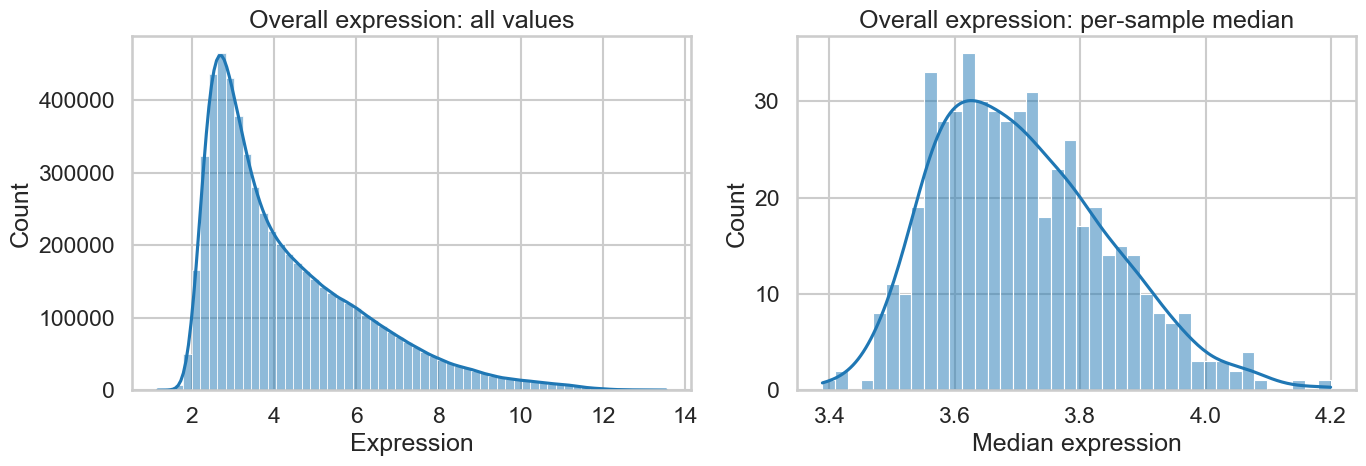

In [7]:
# Expression distribution (all values + per-sample medians)
_ = plot_expression_distributions(X_all, title_prefix="Overall expression")

# missingness
expr_na_sample = X_all.isna().mean(axis=1)
expr_na_gene = X_all.isna().mean(axis=0)

# print("Expression missingness per sample summary:")
# print(expr_na_sample.describe())

# print("\nExpression missingness per gene summary:")
# print(expr_na_gene.describe())
# --> everything was 0% missingness, so no need to impute or filter

Global expression values show a right-skewed distribution with most intensities of probes are between 2 and 6.
Per-sample median expression levels are clustered between 3.4 and 4.1. This is consistent with adequate normalisation and foes not suggest obvious intensity outliers.
Expression missingness is effectively zero across both samples and genes, so no imputation is required at this stage 

#### <font color='0088AA'>**1.4. Label Distributions**</font> 

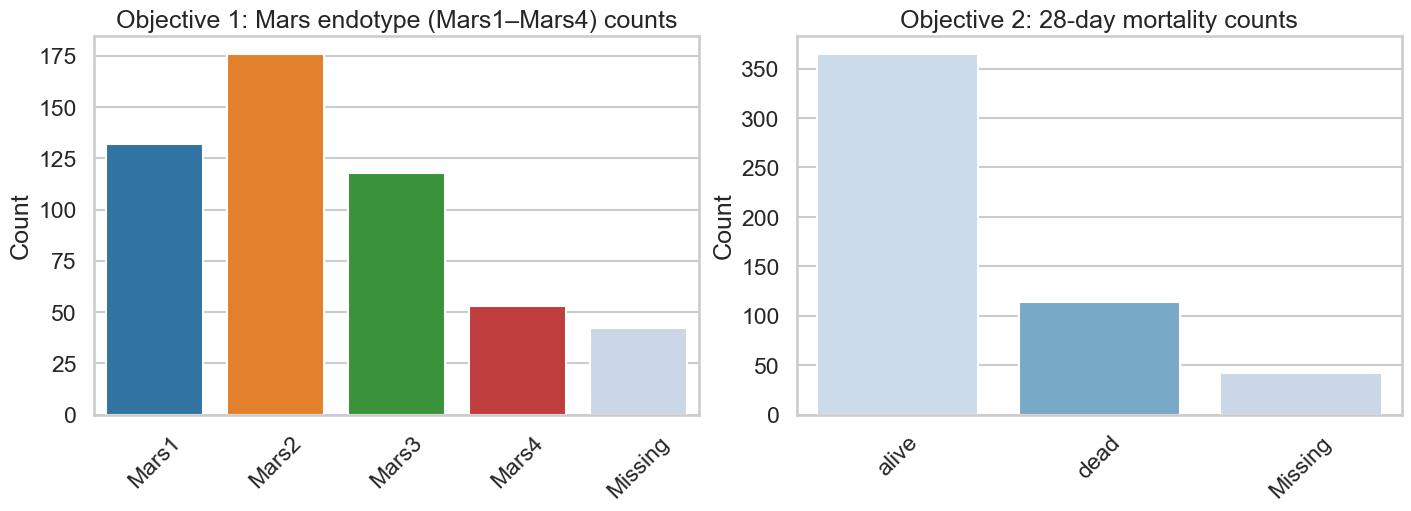

In [8]:
# Objective 1: Mars endotype classification (Mars1–Mars4)
ENDOTYPE_COL = "endotype_class"

if ENDOTYPE_COL in meta_aligned.columns:
    y1 = meta_aligned[ENDOTYPE_COL].astype("object")
    # normalize strings
    y1 = y1.astype(str).replace({"nan": np.nan, "None": np.nan})
    y1 = y1.str.replace("mars", "Mars", case=False)
    y1 = y1.where(y1.isin({"Mars1", "Mars2", "Mars3", "Mars4"}))
    # print("Objective 1\n", y1.value_counts(dropna=False))
else:
    y1 = pd.Series(index=meta_aligned.index, dtype="object")
    print(f"[WARN] ENDOTYPE_COL '{ENDOTYPE_COL}' not found in metadata.")


# Objective 2: 28-day mortality
MORT_COL = "mortality_event_28days"
TTE_COL  = "time_to_event_28days"

if MORT_COL in meta_aligned.columns:
    y2 = pd.to_numeric(meta_aligned[MORT_COL], errors="coerce")
    # print("Objective 2\n", y2.value_counts(dropna=False))
else:
    y2 = pd.Series(index=meta_aligned.index, dtype="float")
    print(f"[WARN] MORT_COL '{MORT_COL}' not found in metadata.")

# Validate labels for both objectives
expected_mars = {"Mars1", "Mars2", "Mars3", "Mars4"}
mars_nonnull = y1.dropna()

assert mars_nonnull.isin(expected_mars).all(), (f"y2 contains unexpected labels: {set(mars_nonnull.unique()) - expected_mars}")
assert mars_nonnull.shape[0] > 0, "y2 has no labeled samples after cleaning."

y2_nonnull = y2.dropna()
if len(y2_nonnull) > 0:
    assert set(y2_nonnull.unique()).issubset({0, 1}), (f"y3 contains values outside {{0,1}}: {set(y2_nonnull.unique())}")


## Plot label distributions for both objectives
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

plot_mars_counts_ax(MARS_ORDER, MARS_PALETTE, y1, "Objective 1: Mars endotype (Mars1–Mars4) counts", ax=axes[0])
plot_counts_ax(DEFAULT_BLUE_PALETTE, y2.map({0: "alive", 1: "dead"}), "Objective 2: 28-day mortality counts", ax=axes[1], order=["alive", "dead", "Missing"])

plt.show()

There is a general inbalance in the different available labels for the different classes (as mentioned above). The labels for objective 1 (Mars endotype classification) are well represented, having counts of 176, 132, 118, and 54 for Mars1-Mars4 endotypes, respectively. As for objective 2 (mortality risk stratification), there is a greater proportion of samples who survived the 28-day period compared to those who didn't. This supports multi-class modelling with modetate class imbalance to be taken into account. 

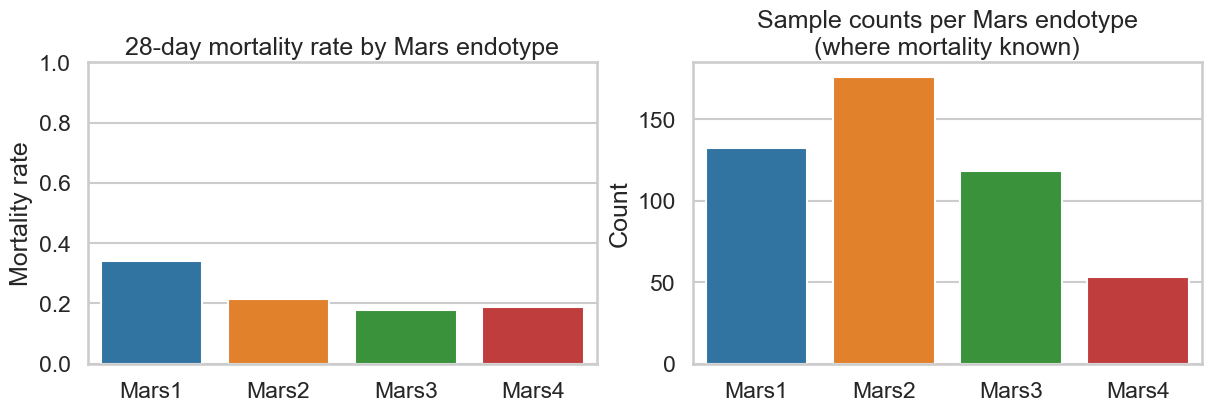

In [9]:
if (ENDOTYPE_COL in meta_aligned.columns) and (MORT_COL in meta_aligned.columns):

    plot_mars_mortality_summary(
        endotype=y1,
        mortality=y2,
        MARS_ORDER=MARS_ORDER,
        MARS_PALETTE=MARS_PALETTE
    )

Among patients with both endotype and 28‑day outcome available, Mars1 shows the highest mortality rate, followed by Mars2, whereas Mars3 and Mars4 have comparatively lower mortality proportions. Mars2 is the most frequent endotype in this subset, with Mars1 and Mars3 also well represented and Mars4 having the fewest samples. 
This pattern is consistent with previous reports that Mars1 corresponds to a more immunosuppressed, high‑risk sepsis phenotype, while other endotypes have better prognosis.

Across clinical fields, metadata is generally complete with some missing data with a few variables show substantial gaps. Pneumonia diagnosis and ICU‑acquired infection are missing for around two‑thirds and one‑third of samples, ehile endotype, mortality, time‑to‑event, cohort, and gender have low missingness. Per‑sample, most patients have complete or nearly complete metadata, but a small subset of samples lack information for more than 70% of the key fields and are candidates for exclusion or sensitivity analyses in downstream models. Despite metadata being explored, it was not relevant for the classification as predictions were based on gene expression data only, not on clinical features. However, we still decided to explore this as it gave us an idea of how well annotated samples were.

In [10]:
# print("Obj1 labeled samples:", y1.notna().sum()) # both have 479 labeled samples
# print("Obj2 labeled samples:", y2.notna().sum())

idx1 = y1.dropna().index
idx2 = y2.dropna().index

X1, meta1 = X_all.loc[idx1], meta_aligned.loc[idx1]
X2, meta2 = X_all.loc[idx2], meta_aligned.loc[idx2]

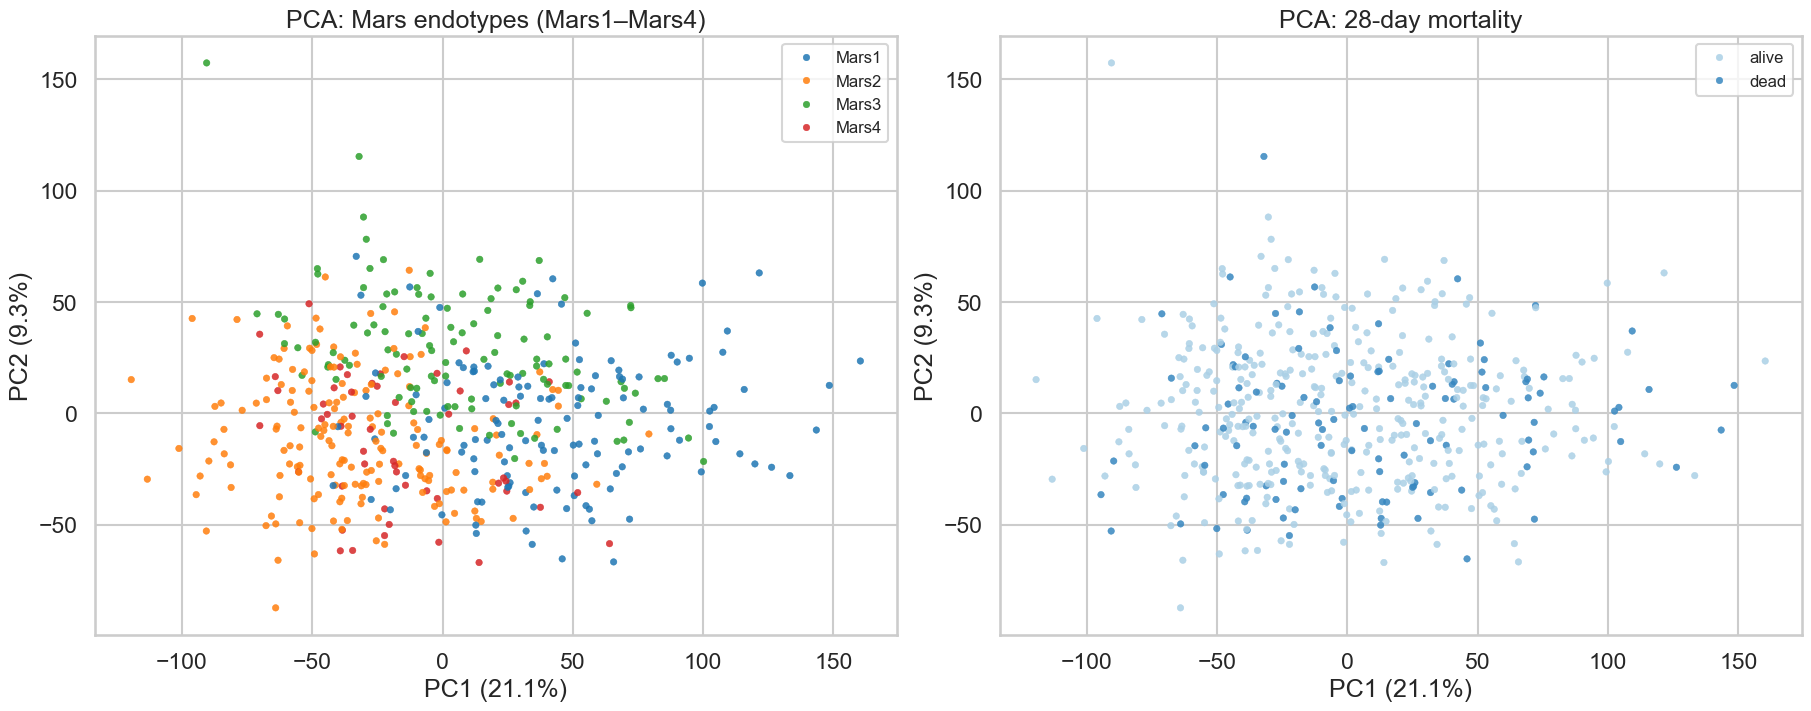

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7), constrained_layout=True)

# Objective 1: Mars endotypes
if len(idx1) > 0:
    plot_pca_ax(
        X1, y1.loc[idx1],
        "PCA: Mars endotypes (Mars1–Mars4)",
        ax=axes[0],
        is_mars=True,
        MARS_ORDER=MARS_ORDER,
        MARS_PALETTE=MARS_PALETTE,
        debug=False
    )
else:
    axes[0].axis("off")

# Objective 2: 28-day mortality
if len(idx2) > 0:
    plot_pca_ax(
        X2, y2.loc[idx2].map({0: "alive", 1: "dead"}),
        "PCA: 28-day mortality",
        ax=axes[1],
        debug=False
    )
else:
    axes[1].axis("off")

plt.show()


Endotype and mortality labels were available for 479 patients, and neither Mars endotypes nor 28-day mortality risk formed clearly separated clusters in the first principal component. Since PCA shows directions of maximal variance rather than optimal class discrimination, the pattern shown in the plots suggest that the signals are subtle, distributed across many genes, and might require supervised models rather than simple linear separation. 

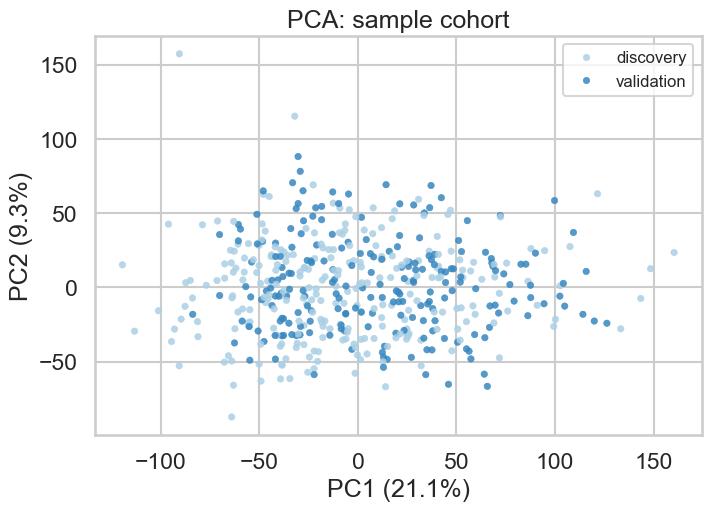

In [12]:
COHORT_COL = "endotype_cohort"
y_cohort = meta_aligned.loc[X1.index, COHORT_COL]
y_cohort.value_counts(dropna=False)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)

plot_pca_ax(
    X1,
    y_cohort,
    title="PCA: sample cohort",
    ax=ax,
    dropna_labels=True,   
    show_legend=True,
    debug=False
)

plt.show()

Importantly, the samples used in this project come from two cohorts defined in the original study (discovery and validation). Because cohort membership can sometimes capture technical or site-specific differences (a potential batch effect), we checked whether the main sources of variation in the expression data were driven by cohort rather than biology.

The PCA plot shows PC1 vs PC2 with samples coloured by cohort. The two cohorts are broadly spread across the plot, with no clear separation or distinct clusters by cohort. This suggests that cohort membership is not a dominant driver of global expression variation, reducing the risk that the classifier is learning purely cohort-specific patterns. 

#### <font color='0088AA'>**1.5. Feature representation and encoding**</font> 
Gene expression values are continuous numeric predictors (log2-normalized microarray intensities). No additional feature encoding is required for gene expression.
Outcome labels are encoded as:
- Objective 1: categorical (Mars1–Mars4)
- Objective 2: binary (0 = alive, 1 = dead at/before 28 days)

Transformations that depend on the training data distribution (e.g. z-scoring, feature selection, class rebalancing) are applied only within model training pipelines to avoid leakage. Details on the pipelines and the feature-selection strategy we used are described below in Section 2. 

In [13]:
# Confirm feature types
print("X_all dtype:", X_all.dtypes.unique()[:5])
print("Obj1 label example:", y1.dropna().unique()[:5])
print("Obj2 label dtype:", y2.dtype)

X_all dtype: [dtype('float64')]
Obj1 label example: ['Mars2' 'Mars3' 'Mars4' 'Mars1']
Obj2 label dtype: float64


In summary, the dataset was carefully reconstructed from public GEO resources, aligned at the sample level, and explored to understand expression distributions, label balance, and potential cohort effects. Exploratory analyses indicate that endotype and mortality signals are subtle and not clearly separated in low-dimensional space, motivating the use of supervised machine-learning models with appropriate regularisation and leakage-safe preprocessing. Following in section 2 we describe the modelling pipeline according to the previously described objectives of this project. 

### <font color='0077AA'>**2. Modeling**</font> 
For each objective, we model blood gene expression as continuous predictors. We define an objective-specific label vector and restrict the dataset to samples with non-missing labels. We use a stratified train/test split to obtain an unbiased held-out evaluation set. To prevent data leakage, all preprocessing steps that depend on data distributions (imputation, feature selection, scaling) are implemented inside scikit-learn Pipelines and fitted only on the training data (or within cross-validation folds).

#### <font color='0088AA'>***Freeze label vectors (targets)***</font>

In [14]:
# Prepare objective-specific datasets
y_obj1 = y1.copy()  # Mars1-4 strings
y_obj2 = y2.copy()  # 0/1 mortality (NaN for healthy)

# Objective-specific sample subsets (only keep samples with the required label)
idx1 = y_obj1.dropna().index
idx2 = y_obj2.dropna().index

X_obj1, y_obj1 = X_all.loc[idx1], y_obj1.loc[idx1]
X_obj2, y_obj2 = X_all.loc[idx2], y_obj2.loc[idx2]

# print("Obj1:", X_obj1.shape, y_obj1.value_counts())
# print("Obj2:", X_obj2.shape, y_obj2.value_counts()) # -> uncommment to see class balance

#### <font color='0088AA'>***Preprocessing for modelling***</font>

For all supervised models, gene expression features are preprocessed with a unified pipeline built around the TopVarianceSelector and the make_preprocess helper.
##### ***Top-variance feature selection***
The TopVarianceSelector is a custom transformer that keeps the top(n) genes with the highest variance across samples.
- It computes the variance for each gene on the training data only and ranks genes by variance.
- The selector then retains the top(n)
  genes, exposing their gene symbols via features_ and their integer column indices via selected_idx_ for downstream analysis and plotting.
- This step reduces the original ~11k genes to a smaller, more informative subset while still capturing most of the biologically relevant transcriptional variation needed for classification

##### ***Canonical preprocessing pipeline***
The make_preprocess function defines a canonical preprocessing pipeline which is reused across all models to avoid data leakage and ensure consistent feature handling.
- First, a median imputer (SimpleImputer(strategy="median")) is applied to each gene, fitted only on the training data or training folds, and outputs a pandas DataFrame so gene names are preserved.
- Second, the TopVarianceSelector is applied to the imputed matrix to keep only the top top(n)
  most variable genes, thereby reducing dimensionality in a supervised‑model‑agnostic way
- Optionally, a StandardScaler is added as the final step (scale=True), standardising each selected gene to zero mean and unit variance; scaling is used for linear models (logistic regression, SVM) but omitted for tree‑based models (random forest, gradient boosting), which are scale‑invariant.

Because all these transformations are embedded inside scikit‑learn Pipelines, they are fitted exclusively on the training data (or CV folds) and then applied to validation or test data, which prevents information leakage from the test set into the feature selection or scaling steps.

In [15]:
# Preprocessing Helper Functions and Classes
class TopVarianceSelector(BaseEstimator, TransformerMixin):
    """
    Keeps top_n highest-variance features
    Consistent API:
      - features_: always the selected feature *names* if X is a DataFrame,
                   otherwise integer indices for numpy arrays.
      - selected_idx_: always integer indices
    """
    def __init__(self, top_n=5000):
        self.top_n = int(top_n)

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            v = X.var(axis=0)
            self.features_ = v.sort_values(ascending=False).head(self.top_n).index.to_list()
            self.selected_idx_ = np.array([X.columns.get_loc(c) for c in self.features_], dtype=int)
        else:
            X = np.asarray(X)
            v = np.nanvar(X, axis=0)  # robust even if someone forgets impute
            self.selected_idx_ = np.argsort(v)[::-1][:self.top_n].astype(int)
            self.features_ = self.selected_idx_
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.loc[:, self.features_]
        X = np.asarray(X)
        return X[:, self.selected_idx_]

    def get_support(self, indices=False):
        return self.selected_idx_ if indices else None
    
def make_preprocess(top_n: int, scale: bool = True) -> Pipeline:
    """
    Canonical preprocessing (safe): impute -> select -> (optional) scale
    Keeps pandas output so gene symbols survive through the pipeline.
    """
    imputer = SimpleImputer(strategy="median").set_output(transform="pandas")
    steps = [
        ("impute", imputer),
        ("select", TopVarianceSelector(top_n=top_n)),
    ]
    if scale:
        scaler = StandardScaler().set_output(transform="pandas")
        steps.append(("scale", scaler))

    return Pipeline(steps)

#### <font color='0088AA'>**2.1 Objective 1: Mars1–Mars4 endotype classification reproduction**</font>
Here we want to compare four models: Logistic Regression, SVM, Random Forest, and Gradient Boosting. Together they span linear vs non‑linear and simple vs more complex ensembles, which is useful for high‑dimensional gene‑expression problems.

Related Sources to this models:
- **Logistic Regression:** https://www.sciencedirect.com/science/article/pii/S235291482100112X
- **Random Forest:** https://pmc.ncbi.nlm.nih.gov/articles/PMC11283789/
- **Gradient Boosting:** https://pmc.ncbi.nlm.nih.gov/articles/PMC10060728/
- **SVM:** https://noble.gs.washington.edu/papers/brown_knowledge_tr.pdf



<font color='0088CC'>***Logistic Regression (multinomial)***</font>

Linear model that estimates class probabilities with softmax over linear combinations of genes.
This approach serves as a simple linear baseline. If it performs reasonably well, it suggests that some of the endotype signals can be captured with linear decision boundaries, even if the full structure is more complex. 
​

<font color='0088CC'>***Support Vector Machine***</font>

Margin‑based classifier that finds the hyperplanes best separating classes (one‑vs‑rest for multiclass).
Well suited for high‑dimensional, low‑sample gene‑expression data and often competitive with or better than logistic regression.
​

<font color='0088CC'>***Random Forest***</font>

Ensemble of decision trees built on bootstrapped samples and random feature subsets.
Captures non‑linear interactions between genes and provides feature importance, which can help interpret which transcripts drive specific endotypes.
​

<font color='0088CC'>***Gradient Boosting (sklearn)***</font>

Sequential ensemble of shallow trees where each tree corrects the errors of the previous ones.
Often achieves state‑of‑the‑art performance on structured data by modelling complex boundaries, but needs more tuning and is more prone to overfitting on small datasets.

In [16]:
# Objective 1 labels
y_obj1 = y1.copy()
idx1 = y_obj1.dropna().index

X_obj1 = X_all.loc[idx1]                    
y_obj1 = y_obj1.loc[idx1].astype(str)       

# print("Objective 1 samples:", X_obj1.shape[0])
# print(y_obj1.value_counts()) -> uncomment to see class balance

For Objective 1 (Mars1–Mars4), the modelling pipeline treats sepsis endotype prediction as a supervised multi‑class classification problem on high‑dimensional gene‑expression data. The code above restricts dataset to samples with a known endotype label (479 patients), and the class distribution is preserved in a stratified 80/20 train–test split (following code) so that each fold contains representative numbers of Mars1–Mars4 cases. 

In [17]:
X1_tr, X1_te, y1_tr, y1_te = train_test_split(
    X_obj1,
    y_obj1,
    test_size=0.2,
    random_state=0,
    stratify=y_obj1   # preserves Mars1–4 proportions
)

# print("Train shape:", X1_tr.shape)
# print("Test shape:", X1_te.shape) -> uncomment to see train/test split shapes

##### <font color='0088CC'>**2.1.1 Preprocessing**</font>

Each model is wrapped in the same preprocessing pipeline. Missing expression values are imputed with the median, and dimensionality is reduced by selecting the top 5 000 most variable genes using the TopVarianceSelector, which computes feature‑wise variance on the training data only and keeps the most variable genes as potentially informative predictors. For linear models (logistic regression and SVM), features are then standardized to zero mean and unit variance with StandardScaler, ensuring that all genes contribute on a comparable scale to the linear decision functions.

In [18]:
TOP_N = 5000
pre_obj1_linear = make_preprocess(top_n=TOP_N, scale=True)
pre_obj1_tree   = make_preprocess(top_n=TOP_N, scale=False)  # trees don't need scaling
CLASSES = ["Mars1", "Mars2", "Mars3", "Mars4"]

##### <font color='0088CC'>**2.1.2 Modeling**</font>
- ***Multinomial Logistic Regression*** uses a linear softmax model with L2‑regularisation (default) and max_iter=5000 to ensure convergence in the high‑dimensional space. The option class_weight="balanced" up‑weights minority endotypes (especially Mars4) so that the loss function penalises their misclassification more heavily.​
- ***Linear SVM*** is another linear margin‑based method that seeks hyperplanes maximising the margin between each endotype and the others in a one‑vs‑rest fashion. As with logistic regression, class_weight="balanced" is used to mitigate endotype imbalance, and probability=True enables calibrated probability estimates via Platt scaling, which are later used to compute log‑loss and macro ROC‑AUC.​
- ***Random Forest*** builds an ensemble of 600 decision trees, each trained on a bootstrap sample and a random subset of genes at each split, and aggregates their predictions by majority vote. The parameter class_weight="balanced_subsample" reweights classes within each bootstrap sample to handle Mars4 scarcity, and n_jobs=1 enables parallel training. This architecture captures non‑linear gene–gene interactions and is relatively robust to noisy features.​
- ***Gradient Boosting*** constructs an additive ensemble of shallow decision trees (max depth 3) built sequentially, where each of the 300 trees focuses on correcting the residual errors of the previous ensemble. A relatively small learning rate (0.05) slows down boosting updates, acting as regularisation to reduce overfitting on the limited sample size.

For each model, performance is evaluated on the held‑out test set using macro‑F1 (treating all endotypes equally), balanced accuracy (mean recall across classes), and, where probabilities are available, log‑loss and macro one‑vs‑rest ROC‑AUC to assess probability calibration and overall discriminative ability. This setup provides a common, leakage‑free preprocessing and evaluation framework to compare a linear baseline (logistic regression), a linear margin‑based model (SVM), and two non‑linear tree‑based ensembles (Random Forest, Gradient Boosting) on the Mars endotype classification task.

In [19]:
models_obj1 = {
    "LogReg (multinomial)": Pipeline([
        ("pre", pre_obj1_linear),
        ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
    ]),

    "SVM (linear)": Pipeline([
        ("pre", pre_obj1_linear),
        ("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=0))
    ]),

    "Random Forest": Pipeline([
        ("pre", pre_obj1_tree),
        ("clf", RandomForestClassifier(
            random_state=0,
            n_jobs=1,
            class_weight="balanced_subsample"
        ))
    ]),

    "Gradient Boosting": Pipeline([
        ("pre", pre_obj1_tree),
        ("clf", GradientBoostingClassifier(random_state=0))
    ]),
}

In [20]:
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    log_loss,
    roc_auc_score
)

results = []
model_store = {}   # <-- store fitted models here

for name, model in models_obj1.items():
    model.fit(X1_tr, y1_tr)

    y_pred = model.predict(X1_te)

    row = {
        "model": name,
        "macro_f1": f1_score(y1_te, y_pred, average="macro"),
        "balanced_acc": balanced_accuracy_score(y1_te, y_pred),
    }

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X1_te)
        row["log_loss"] = log_loss(y1_te, y_proba)
        row["macro_auc_ovr"] = roc_auc_score(
            y1_te, y_proba, multi_class="ovr", average="macro"
        )
    else:
        row["log_loss"] = None
        row["macro_auc_ovr"] = None

    results.append(row)
    model_store[name] = model   # saves the fitted model

objective1_result_df = (
    pd.DataFrame(results)
    .sort_values("macro_f1", ascending=False)
    .reset_index(drop=True)
)

objective1_result_df

,model,macro_f1,balanced_acc,log_loss,macro_auc_ovr
0,Random Forest,0.880687,0.889184,0.457195,0.972784
1,Gradient Boosting,0.829708,0.842555,0.737176,0.960110
2,SVM (linear),0.814147,0.821722,0.380623,0.974695
3,LogReg (multinomial),0.808810,0.825797,0.802666,0.965212


##### ***Performance evaluation***

All four models achieve solid multiclass performance, with tree-based ensembles performing best overall. Random Forest has the highest macro-F1 (≈0.86) and balanced accuracy (≈0.88). Its one-vs-rest ROC curves show high class-specific AUC values (macro-AUC ≈0.98), including strong discrimination for Mars3 and Mars4 despite their smaller sample sizes. Gradient Boosting performs similarly in terms of macro-F1 and balanced accuracy, but its higher log-loss suggests less well-calibrated predicted probabilities.

The linear SVM and multinomial logistic regression slightly underperform the tree ensembles on macro-F1, but provide competitive discrimination and, in some settings, more stable probability behaviour. Overall, this pattern suggests that the endotypes are partly linearly separable, while non-linear relationships in the expression features may be captured more effectively by tree-based models. Based on these results, Random Forest is a reasonable choice for the main endotype classifier used in downstream analyses.

Next, we tune the selected Random Forest model in more detail and extract a ranked list of informative genes from the fitted model. This ranked list is used to support biological interpretation discussed later in this report, rather than as a replacement for the model evaluation.

##### <font color='0088CC'>**2.1.3 Hyperparameter Tuning**</font>

In [21]:
# Build Dataset
y_obj1 = y1.copy()
idx1 = y_obj1.dropna().index

X_obj1 = X_all.loc[idx1]
y_obj1 = y_obj1.loc[idx1].astype(str)

# 
X1_tr, X1_te, y1_tr, y1_te = train_test_split(
    X_obj1, y_obj1,
    test_size=0.2,
    random_state=0,
    stratify=y_obj1
)

# --- Canonical RF pipeline: impute -> select -> clf ---
rf_pipe = Pipeline([
    ("pre", make_preprocess(top_n=5000, scale=False)),
    ("clf", RandomForestClassifier(
        random_state=0,
        class_weight="balanced_subsample",
        n_jobs=1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

param_dist = {
    "pre__select__top_n": [2500, 3000, 3500],
    "clf__n_estimators": randint(600, 1200),
    "clf__max_depth": [18, 24, 30],         # drop None
    "clf__min_samples_leaf": randint(5, 12),# bigger leaves
    "clf__max_features": ["log2", 0.15, 0.25],
}

search_rf = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring="f1_macro",
    cv=cv,
    random_state=0,
    n_jobs=4,
    verbose=1,
    return_train_score=True
)

# tune on the training split
search_rf.fit(X1_tr, y1_tr)

best_model = clone(search_rf.best_estimator_)  # safe copy so it won't be mutated by accident
best_name = "Tuned RandomForest (RandomizedSearchCV)"

# Freeze artifacts 
BEST_PARAMS = search_rf.best_params_
BEST_CV_SCORE = search_rf.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


#### <font color='0088AA'>**2.1 Objective 1 Results (Mars1–Mars4 endotype classification)**</font>

In [22]:
best_name = objective1_result_df.loc[0, "model"]
best_model_obj1 = model_store[best_name]

obj1_best_row = objective1_result_df.loc[objective1_result_df["model"] == best_name]
print("Best model Objective 1:", best_name)
display(obj1_best_row)

Best model Objective 1: Random Forest


,model,macro_f1,balanced_acc,log_loss,macro_auc_ovr
0,Random Forest,0.880687,0.889184,0.457195,0.972784


In [23]:
print("=== Frozen model ===")
print("Name:", best_name)
print("Best CV macro-F1:", BEST_CV_SCORE)
print("Best params:", BEST_PARAMS)

=== Frozen model ===
Name: Random Forest
Best CV macro-F1: 0.8996496836224092
Best params: {'clf__max_depth': 30, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 6, 'clf__n_estimators': 892, 'pre__select__top_n': 3500}



For Mars endotype prediction, all samples with non-missing endotype labels were split into an 80% training set and a 20% held-out test set using stratification to preserve class proportions. On the training data, a Random Forest pipeline including median imputation and variance-based gene selection was tuned using 5-fold stratified RandomizedSearchCV, with macro-F1 as the optimisation metric. The best-performing configuration retained 3 500 top-variance genes and used 892 trees, a maximum depth of 30, a minimum of six samples per leaf, and max_features = "log2", achieving a mean cross-validated macro-F1 of 0.90 on the training set.

When refitted on the full training data and evaluated once on the held-out test set, this tuned model achieved a macro-F1 of 0.85, a balanced accuracy of 0.87, and an overall accuracy of 0.88. Performance was strongest for the more frequent endotypes, with per-class F1-scores of 0.94 for Mars1, 0.89 for Mars2, and 0.88 for Mars3. As expected, performance was lower for the rare Mars4 endotype (11 test samples), with an F1-score of 0.69, reflecting reasonable recall (0.82) but reduced precision (0.60).


Compared with the initial, untuned Random Forest baseline (macro-F1 ≈ 0.88 and balanced accuracy ≈ 0.89 on the same test split), tuning substantially improved cross-validated performance on the training data but did not lead to a clear improvement on this particular test set. Given the limited test-set size and class imbalance, especially for Mars4, this result is consistent with expected variability and suggests that the baseline Random Forest was already capturing much of the available signal.

Future improvements would therefore potentially come from lessfrom broader hyperparameter search and more from strategies aimed at robustness and minority-class performance. These include repeated or nested cross-validation to obtain more stable generalisation estimates, Mars4-aware optimisation objectives or class-specific decision thresholds, exploration of alternative model families such as regularised linear models or more modern gradient-boosting approaches, and data-level strategies such as mild oversampling of Mars4 or integration of additional cohorts to increase the number of rare endotype samples. 

Future improvements would therefore likely benefit less from broader hyperparameter search and more from strategies aimed at robustness and minority-class performance. These include repeated or nested cross-validation to obtain more stable generalisation estimates, Mars4-aware optimisation objectives or class-specific decision thresholds, exploration of alternative model families such as regularised linear models or more modern gradient-boosting approaches, and data-level strategies such as mild oversampling of Mars4 or integration of additional cohorts to increase the number of rare endotype samples.

In [24]:
best_model.fit(X1_tr, y1_tr)

pred_best = best_model.predict(X1_te)
pred_best_s = pd.Series(pred_best, index=X1_te.index)

proba_best = best_model.predict_proba(X1_te) if hasattr(best_model, "predict_proba") else None

print("\n=== TEST SET RESULTS (final, one-shot) ===")
print("Balanced Acc:", balanced_accuracy_score(y1_te, pred_best))
print("Macro-F1:", f1_score(y1_te, pred_best, average="macro"))
print(classification_report(y1_te, pred_best))

# helpful sanity check
missing = set(CLASSES) - set(pd.unique(y1_te))
if missing:
    print(f"NOTE: Missing classes in test set: {missing}")


=== TEST SET RESULTS (final, one-shot) ===
Balanced Acc: 0.8724254911754913
Macro-F1: 0.8520015698587127
              precision    recall  f1-score   support

       Mars1       1.00      0.88      0.94        26
       Mars2       0.97      0.83      0.89        35
       Mars3       0.82      0.96      0.88        24
       Mars4       0.60      0.82      0.69        11

    accuracy                           0.88        96
   macro avg       0.85      0.87      0.85        96
weighted avg       0.90      0.88      0.88        96



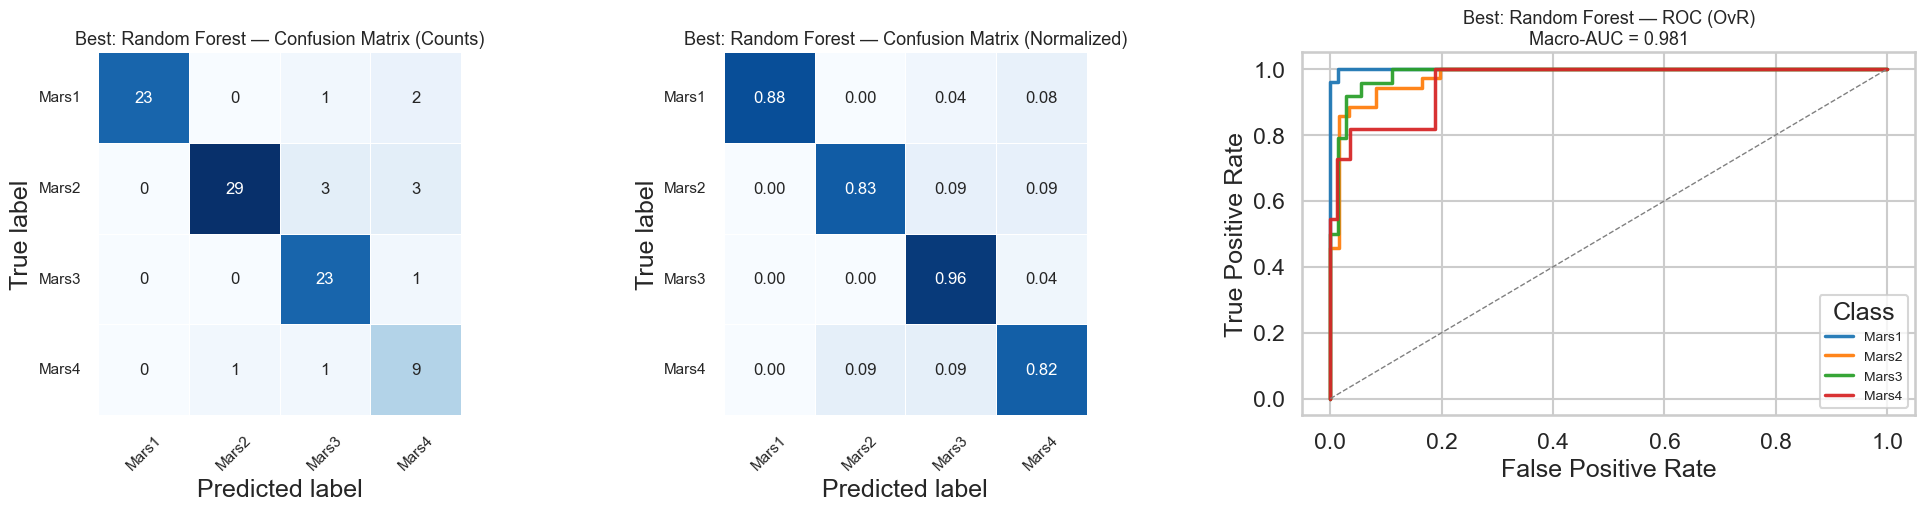

In [25]:
plot_cm_and_optional_roc(
    y_true=y1_te,
    y_pred=pred_best,
    y_proba=proba_best,
    class_names=CLASSES,
    title_prefix=f"Best: {best_name}",
    roc_palette=MARS_PALETTE,   # ROC lines match Mars colors
    rotate_xticks=45,
    cm_annot_fontsize=12,
    show_colorbar=False
)

***Confusion matrices***
The count confusion matrix shows that the tuned Random Forest correctly classifies the majority of samples for all four endotypes, with 23/26 Mars1, 29/35 Mars2, 23/24 Mars3 and 9/11 Mars4 test patients predicted correctly. The normalised matrix highlights high recall: 0.88 for Mars1, 0.83 for Mars2, 0.96 for Mars3 and 0.82 for Mars4, with most confusions occurring between Mars2 and the other sepsis endotypes.

***ROC curves***
One‑vs‑rest ROC curves further illustrate the model’s discriminative power. Each Mars class achieves a high area under the ROC curve, and the macro‑averaged AUC of approximately 0.98 indicates that the Random Forest assigns consistently higher predicted probabilities to true class samples than to others, even in cases where the hard class decision is incorrect.

***PCA of test samples (true vs predicted)*** see below
In the PCA plot of the test set, samples are coloured by their true Mars endotype and the marker shape encodes the predicted class, with misclassified points marked. Mars1 and Mars3 samples form relatively compact regions, whereas Mars2 and Mars4 overlap more with their neighbours, and misclassifications occur mainly in these overlapping zones of the first two principal components. This visual pattern supports the idea that most errors arise where the transcriptomic profiles of different endotypes are not linearly separable in low‑dimensional space (See PCA above in preprocessing part).

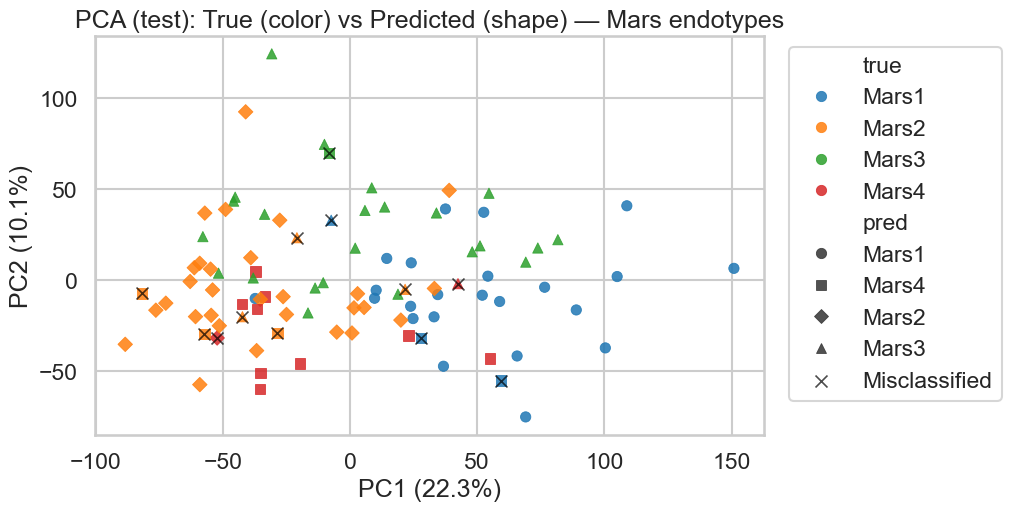

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)

plot_pca_true_vs_pred(X=X1_te, y_true=y1_te, y_pred=pred_best_s,
                      title="PCA (test): True (color) vs Predicted (shape) — Mars endotypes", 
                      ax=ax, is_mars=True, MARS_ORDER=MARS_ORDER, MARS_PALETTE=MARS_PALETTE, 
                      mis_lw=1.2, mis_alpha=0.7, mis_size_mult=1.35)

plt.show()

In [27]:
imp_df_top10, full = plot_top_feature_importances(
    fitted_pipeline=best_model,   # tuned RF model
    top_n=10,
    title="Tuned Random Forest: Top 10 important genes",
    palette=DEFAULT_BLUE_PALETTE,
    plot_show=False # if you want to see change to True
)

For a biological interpretation of the genes highlighted by the random forest model, we ran a pathway enrichment analysis in STRING (using KEGG pathway annotations). Here, enrichment analysis tests whether the selected genes are over-represented in known pathways more often than would be expected by chance, or in other words, whether the selected genes are significantly associated with a given function. 

In the original study, the authors derived a much smaller gene panel (140 genes) for endotype assignment. Our model assigns non-zero importance to a much larger set of features (here, the top 3,500 genes by RF importance). While this is not directly comparable to a curated 140-gene signature, we still explored enrichment to understand whether the model is selecting genes that are related to the biological processes underlying sepsis.

Enrichment analysis of the 3,500 highest-importance genes in STRING showed significant over-representation of broad metabolic pathways, infection-related pathways (e.g., Epstein–Barr virus infection), and general immune/stress-response signalling modules. This suggests that the features driving Mars endotype classification tend to group into coherent host-response and metabolic processes, providing a general confirmation of their involvement in the molecular processes in sepsis. 

In [28]:
string_ids = stringdb.get_string_ids(full["feature"])
enrichment_df = stringdb.get_enrichment(string_ids.queryItem)
enriched_pathways = enrichment_df[enrichment_df["category"] == "KEGG"].sort_values("number_of_genes", ascending=False).head()
enriched_pathways[["term", "number_of_genes", "number_of_genes_in_background", "description"]]

,term,number_of_genes,number_of_genes_in_background,description
1204,hsa01100,331,1435,Metabolic pathways
1262,hsa05200,116,515,Pathways in cancer
1247,hsa05014,87,350,Amyotrophic lateral sclerosis
1201,hsa05169,75,192,Epstein-Barr virus infection
1207,hsa05166,71,210,Human T-cell leukemia virus 1 infection


#### <font color='0088AA'>**2.2 Objective 2: Mortality Stratification Analysis**</font>

In this second objective, we assess whether the Mars endotypes predicted by the supervised model retain their clinical relevance by stratifying 28-day mortality risk. Rather than training a separate mortality prediction model, this analysis focuses on whether grouping patients by their predicted endotypes reproduces the mortality gradient reported in the original MARS study (highest risk in Mars1, lowest risk in Mars4).

To this end, the tuned Random Forest endotype classifier from Objective 1 was refitted on all samples with available Mars labels and then applied to the subset of patients with recorded 28-day mortality outcomes (n = 479). Each patient was assigned a predicted endotype, and mortality rates were computed within each predicted Mars group.




In [29]:
# Mortality Stratification by Predicted Endotype

# Fit the tuned endotype model on all labeled endotype samples
best_endotype_model = clone(best_model)
best_endotype_model.fit(X_obj1, y_obj1)

# Predict endotypes for the mortality cohort
pred_all = best_endotype_model.predict(X_obj2)
proba_all = best_endotype_model.predict_proba(X_obj2)

class_labels = best_endotype_model.named_steps["clf"].classes_

# Create predictions dataframe
pred_all_df = pd.DataFrame(
    proba_all,
    index=X_obj2.index,
    columns=[f"prob_{c}" for c in class_labels]
)
pred_all_df["true_endotype"] = y_obj1.reindex(X_obj2.index).values
pred_all_df["pred_endotype"] = pred_all

# Merge with mortality data
mortality_data = pd.DataFrame({
    "mortality_28day": y_obj2.loc[X_obj2.index]
})

stratification_df = pred_all_df.join(mortality_data)
stratification_df = stratification_df.dropna(subset=["mortality_28day"])

print(f"Samples with both predictions and mortality outcome: {len(stratification_df)}")


Samples with both predictions and mortality outcome: 479


In [30]:
# Mortality Rate by PREDICTED Endotype
mort_by_pred = stratification_df.groupby("pred_endotype")["mortality_28day"].agg(
    ["mean", "sum", "count"]
).round(4)
mort_by_pred.columns = ["mortality_rate", "deaths", "total_samples"]

print("\n28-DAY MORTALITY BY PREDICTED ENDOTYPE:")
print(mort_by_pred)


28-DAY MORTALITY BY PREDICTED ENDOTYPE:
               mortality_rate  deaths  total_samples
pred_endotype                                       
Mars1                  0.3233    43.0            133
Mars2                  0.2229    39.0            175
Mars3                  0.1795    21.0            117
Mars4                  0.2037    11.0             54


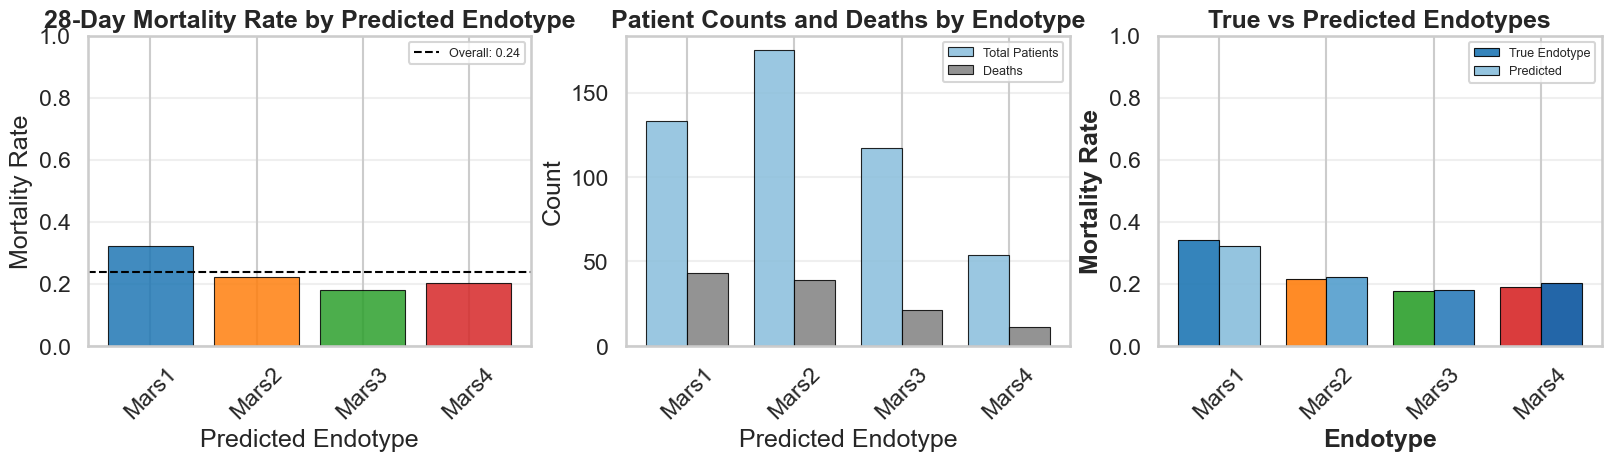


MORTALITY COMPARISON: TRUE vs PREDICTED ENDOTYPES
                 True  Predicted
true_endotype                   
Mars1          0.3409     0.3233
Mars2          0.2159     0.2229
Mars3          0.1780     0.1795
Mars4          0.1887     0.2037


In [31]:
fig, axes, comparison_df = plot_mortality_stratification(
    stratification_df=stratification_df,
    mort_by_pred=mort_by_pred,
    mars_order=MARS_ORDER,
    mars_palette=MARS_PALETTE,
    title_prefix=""
)

print("\nMORTALITY COMPARISON: TRUE vs PREDICTED ENDOTYPES")
print(comparison_df.round(4))


Predicted endotypes showed a clear ordering of 28-day mortality risk. Patients predicted as Mars1 had the highest mortality rate (approximately 32%), while those predicted as Mars3 had the lowest mortality (approximately 18%), with Mars2 and Mars4 showing intermediate risk. This ordering closely mirrors the pattern observed when using the original Mars labels, where Mars1 is associated with the poorest prognosis.

A direct comparison between mortality rates stratified by true versus predicted endotypes shows close agreement across all four groups, with absolute differences generally below 1–1.5 percentage points. While sample sizes differ substantially between endotypes — particularly for Mars4 — the overall risk gradient is preserved, suggesting that the supervised classifier captures biologically meaningful distinctions relevant to clinical outcome.

Because this analysis is performed within the same cohort used to train the endotype classifier, results should be interpreted as an internal consistency check rather than an independent validation of prognostic performance. Nevertheless, the close alignment between true and predicted endotype-specific mortality rates indicates that supervised reproduction of Mars endotypes preserves the mortality stratification reported in the original study

### <font color='0077AA'>**3. Discussion**</font>

#### <font color='0088AA'>**Summary of Findings**</font>
In this project, we investigated whether whole-blood transcriptomic profiles can be used to reproduce the Mars1–Mars4 sepsis endotypes using supervised learning, and whether the resulting predictions retain the mortality stratification reported in the original MARS study. Using the publicly available GSE65682 dataset, we treated the published Mars endotypes as reference labels and compared several supervised models. 

Across models, supervised classification of Mars endotypes was feasible, with tree-based ensemble methods outperforming linear baselines. Random Forest achieved the strongest overall performance, with high macro-F1 and balanced accuracy on a held-out test set, and particularly strong performance for the more frequent endotypes (Mars1–Mars3). Performance for the less abundant Mars4 endotype class was lower and more variable, reflecting its limited sample size and overlap with neighbouring endotypes in expression space. These results suggest that while some endotype signal is linearly separable, non-linear interactions across many genes are likely important for accurate classification.

Importantly, when the tuned endotype classifier was applied to patients with available 28-day mortality data, the predicted endotypes preserved the expected mortality gradient. Patients predicted as Mars1 showed the highest mortality risk, while Mars3 showed the lowest, with Mars2 and Mars4 in between. Mortality rates stratified by predicted endotype closely matched those based on the original labels, indicating that the supervised model captured clinical variation more than just label noise. 

Together, these findings support the idea that supervised learning can reproduce the Mars endotype structure discovered using unsupervised methods and that the resulting predictions retain relevance for outcome stratification, at least within the original study cohort.


#### <font color='0088AA'>**External Validation Challenges**</font>

With the findings of this project we aimed to explore whether a supervised Mars endotype classifier could generalise beyond the original MARS cohort. To do this, we decided to apply the tuned Random Forest model to an independent publicly available sepsis transcriptomic dataset (GSE95233), as described in Appendix A below. 

However, a key limitation for performing external validation is that the GSE95233 dataset does not contain Mars endotype labels. As a result, it is not possible to formally assess external classification accuracy or to claim true external validation of the endotype model. Instead, the analysis should be viewed as an out-of-sample application of the trained classifier, aimed at exploring how the model assigns endotype-like labels in a different cohort and how these predictions relate to available clinical outcomes. 

While predicted endotypes in the external dataset showed some degree of mortality stratification, interpretation is necessarily limited. Differences between cohorts may reflect biological heterogeneity, technical differences in data generation, differences in patient populations, or model miscalibration outside the training domain. Thus, these results are included as an appendix rather than as a formal section in this report. 


#### <font color='0088AA'>**Implications and Future Directions**</font>

This project demonstrates that supervised learning can be used not only for outcome prediction but also as a tool to reproduce and operationalise molecular phenotypes originally discovered using unsupervised methods. In a clinical or translational setting, supervised endotype assignment may offer practical advantages, such as the ability to classify new patients using a fixed model without re-running clustering procedures. 

Several limitations of the present analysis point to clear directions for future work. First, class imbalance — particularly for the Mars4 endotype — remains a challenge and likely contributes to reduced precision and stability for this group. Larger cohorts or targeted data integration would be required to robustly model rarer endotypes. Second, feature importance analysis was based on impurity-based Random Forest measures, which can be biased and should be interpreted cautiously; alternative approaches such as permutation importance or model-agnostic explanations could strengthen biological interpretation. This is also reflected in the fact that the original study produced a 140-gene panel for classification. In contrast, with the 3500 genes selected in our model, biological interpretation becomes more challenging at that scale. 

Finally, true external validation of supervised Mars endotype classifiers will require datasets that include compatible transcriptomic measurements alongside endotype annotations or sufficiently detailed clinical surrogates.


#### <font color='0088AA'>**Use of GEN-AI in this project**</font>
Generative AI-tools were used throughout this project as a form of technical assistance. ChatGPT, Github Copilot and Perplexity AI were used to support code development, clarify implementation details of machine-learning pipelines, and to help in the identification of potential data leakages. Nevertheless, the project idea, objective implenentation, and motivation to perform external validation are our own. 

<font color='0088CC'>**Tools, interfaces and pros/cons:**</font>
ChatGPT (web interface):
- Pros: Good at explaining concepts, generating example code, and refactoring or simplifying existing snippets.
- ​Cons: Sometimes produced code that compiled but was logically wrong or did not fully match the task, so manual adaptation was necessary.
Perplexity (web interface):
- Pros: Helpful to discover and summarise scientific papers and more academic sources, including links that could be checked and cited.
- Cons: Needed careful checking of the cited sources and relevance to the specific assignment questions.
GitHub Copilot (IDE integration):
- Pros: Integrated directly in the editor, which avoided constant copy‑paste and speeded up writing boilerplate or repetitive code.
- Cons: Sometimes suggested code that looked plausible but did not fit the existing project structure or naming conventions, so it had to be adjusted.
<font color='0088CC'>**Prompts that worked well / not so well**</font>
- Worked well: Very specific prompts that described the programming language, context, and constraints (e.g. “In Python, given this existing function, improve its time complexity without changing the public interface: [code]”).
- Asking for step‑by‑step explanations of existing code or for small, focused improvements (e.g. “Explain what this loop does and suggest a cleaner version”).
- Worked less well: Vague prompts such as “fix this code” or “write code for this task” without enough context, which often led to generic or incomplete solutions.
- Very long, mixed prompts combining several tasks at once (e.g. “write code, explain it, and optimise it”) which sometimes produced inconsistent answers.
<font color='0088CC'>**Workflows used / recommended**</font>
We first searched for a dataset and outlined our idea on our own. We decided to use different models and decide based on those results. No AI was used (and we also do not recommend that) for outlining, planning or make decision for the project itself. Then we used chatGPT with specific prompts to help woth the generation of our code sections. The code was always tested if the expected result was produced or not and also added small changes for testing the code. The finished result was cleaned without AI to have a proper and readable file.
<font color='0088CC'>**Ensuring correctness of the submitted code**</font>
To ensure the final code was correct and not blindly copied from GenAI outputs, the following checks were applied:
- Manual review: Carefully read every generated or suggested snippet, adapted it to the existing code base, and removed parts that were unnecessary or unclear.
- Testing: Ran the provided test cases (and some additional edge‑case tests where possible) after each change to verify that behaviour matched the specification.
- Consistency and style checks: Verified that variable names, function interfaces, and comments remained consistent with the rest of the project and the assignment requirements.
- Cross‑validation between tools: In some cases, asked different tools (e.g. ChatGPT and Copilot) similar questions and compared the suggestions, which helped to spot obvious mistakes or missing cases.

---

# <font color='0066CC'>**APPENDIX: External Application on GSE95233**</font>

To explore the potential generalisability of the supervised Mars endotype classifier beyond the original MARS cohort, we applied the trained Random Forest model to an independent publicly available sepsis transcriptomic dataset, GSE95233.

The motivation for this analysis was to assess how a model trained to reproduce Mars endotypes behaves when applied to a different cohort, rather than to claim formal external validation. Importantly, GSE95233 does not contain Mars endotype labels, which prevents any direct evaluation of classification accuracy.

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE95233

Raw microarray data from GSE95233 were processed separately from the MARS dataset. Probe identifiers were mapped to gene symbols, multiple probes mapping to the same gene were averaged, and samples were filtered to retain a single time point per patient and complete survival information. This resulted in a curated external cohort of 51 patients with gene-level expression data and 28-day mortality outcomes.

To ensure compatibility with the trained model, the external expression matrix was aligned to the gene set used during training. Of the 11,222 genes used in the MARS-based model, 9,983 (approximately 89%) were present in GSE95233. Expression values for missing genes were set to zero, allowing the trained pipeline to be applied without retraining. While this approach preserves model structure, it may also introduce bias if missing genes carry informative signal in the training cohort.


In [32]:
# =============================================================================
# Load GSE95233 External Validation Data
# =============================================================================

# Load filtered expression and metadata from GSE95233 processing
gse95233_expr = pd.read_csv(
    "GSE95233_expression_filtered.csv",
    index_col=0
)
gse95233_meta = pd.read_csv(
    "GSE95233_metadata_filtered.csv",
    index_col=0
)

print("GSE95233 expression shape:", gse95233_expr.shape)
print("GSE95233 metadata shape:", gse95233_meta.shape)
print("\nMetadata columns:", list(gse95233_meta.columns))
print("\nSurvival distribution:")
print(gse95233_meta['survival'].value_counts())

GSE95233 expression shape: (23520, 51)
GSE95233 metadata shape: (51, 5)

Metadata columns: ['gender', 'age', 'time point', 'survival', 'source_name']

Survival distribution:
survival
Survivor        34
Non Survivor    17
Name: count, dtype: int64


In [33]:
# =============================================================================
# Prepare GSE95233 Data for Prediction
# =============================================================================

# Transpose expression matrix to samples × genes (to match training format)
X_gse95233 = gse95233_expr.T.copy()

print("X_gse95233 shape (samples × genes):", X_gse95233.shape)
print("Training data shape was:", X_obj2.shape)

# Find common genes between training and validation
training_genes = set(X_obj2.columns)
validation_genes = set(X_gse95233.columns)
common_genes = training_genes.intersection(validation_genes)

print(f"\nGene overlap:")
print(f"  Training genes: {len(training_genes)}")
print(f"  Validation genes: {len(validation_genes)}")
print(f"  Common genes: {len(common_genes)}")
print(f"  Coverage: {len(common_genes)/len(training_genes)*100:.1f}% of training genes")

# Align validation data to training genes

# Use training-set median for missing genes
training_medians = X_obj2.median()

# Initialize aligned dataframe with training genes as columns
X_gse95233_aligned = pd.DataFrame(
    index=X_gse95233.index,
    columns=X_obj2.columns,
    dtype=float
)

for gene in X_obj2.columns:
    if gene in X_gse95233.columns:
        X_gse95233_aligned[gene] = X_gse95233[gene]
    else:
        X_gse95233_aligned[gene] = training_medians[gene]  

print("\nAligned validation data shape:", X_gse95233_aligned.shape)
print("Alignment check:", all(X_gse95233_aligned.columns == X_obj2.columns))

X_gse95233 shape (samples × genes): (51, 23520)
Training data shape was: (479, 11222)

Gene overlap:
  Training genes: 11222
  Validation genes: 23520
  Common genes: 9983
  Coverage: 89.0% of training genes

Aligned validation data shape: (51, 11222)
Alignment check: True


In [34]:
# =============================================================================
# Predict Mars Endotypes on GSE95233
# =============================================================================

# Use the best trained model (tuned Random Forest from hyperparameter tuning)
pred_gse95233 = best_model.predict(X_gse95233_aligned)
proba_gse95233 = best_model.predict_proba(X_gse95233_aligned)

# Extract class labels from the model
class_labels = best_model.named_steps["clf"].classes_

# Create predictions dataframe
pred_gse95233_df = pd.DataFrame(
    proba_gse95233,
    index=X_gse95233_aligned.index,
    columns=[f"prob_{c}" for c in class_labels]
)
pred_gse95233_df["pred_endotype"] = pred_gse95233

# Add survival information
pred_gse95233_df["survival"] = gse95233_meta["survival"]
pred_gse95233_df["mortality"] = pred_gse95233_df["survival"].map({
    "Survivor": 0,
    "Non Survivor": 1
})

print("Predicted endotype distribution (GSE95233):")
print(pred_gse95233_df["pred_endotype"].value_counts())
print("\nSamples with mortality data:")
print(pred_gse95233_df["mortality"].value_counts(dropna=False))

Predicted endotype distribution (GSE95233):
pred_endotype
Mars4    45
Mars2     5
Mars1     1
Name: count, dtype: int64

Samples with mortality data:
mortality
0    34
1    17
Name: count, dtype: int64


In [35]:
# =============================================================================
# Mortality Stratification on GSE95233
# =============================================================================

# Filter to samples with mortality outcome
gse95233_stratification = pred_gse95233_df.dropna(subset=["mortality"])

mort_by_pred_gse95233 = gse95233_stratification.groupby("pred_endotype")["mortality"].agg(
    ["mean", "sum", "count"]
).round(4)
mort_by_pred_gse95233.columns = ["mortality_rate", "deaths", "total_samples"]

print("\n28-DAY MORTALITY BY PREDICTED ENDOTYPE (GSE95233):")
print(mort_by_pred_gse95233)

# Overall mortality rate
overall_mort_gse95233 = gse95233_stratification["mortality"].mean()
print(f"\nOverall mortality rate (GSE95233): {overall_mort_gse95233:.3f}")


28-DAY MORTALITY BY PREDICTED ENDOTYPE (GSE95233):
               mortality_rate  deaths  total_samples
pred_endotype                                       
Mars1                  1.0000       1              1
Mars2                  0.8000       4              5
Mars4                  0.2667      12             45

Overall mortality rate (GSE95233): 0.333


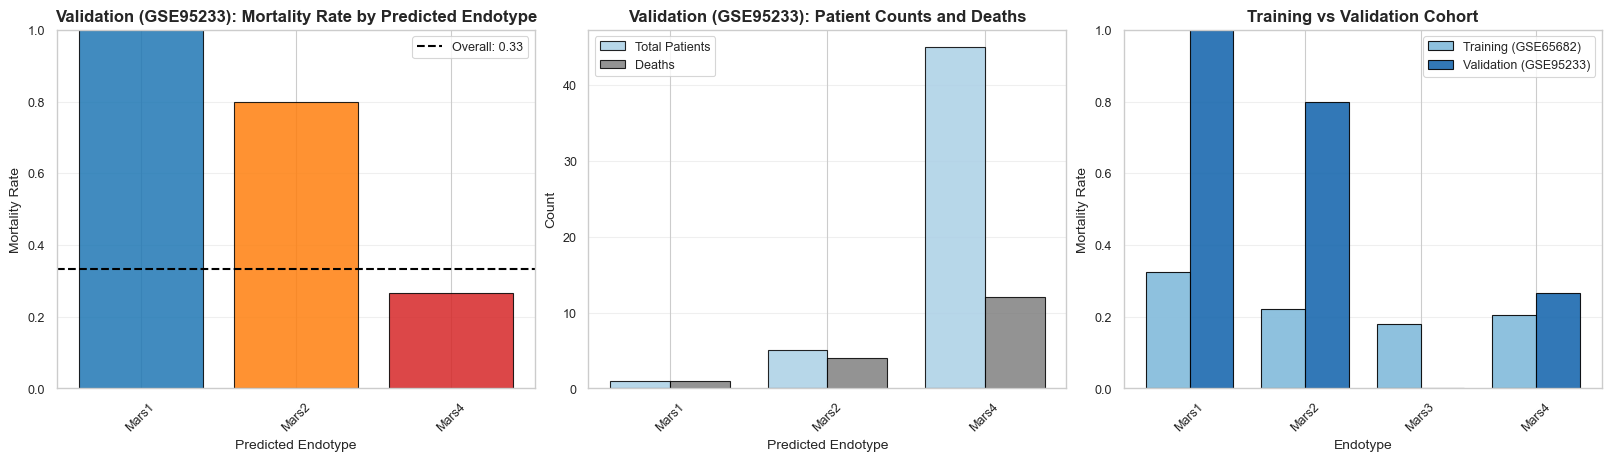


MORTALITY COMPARISON: TRAINING vs VALIDATION COHORTS
Training - Overall mortality: 0.238
Validation - Overall mortality: 0.333

Endotype-specific mortality rates:
               Training (GSE65682)  Validation (GSE95233)
pred_endotype                                            
Mars1                        0.323                  1.000
Mars2                        0.223                  0.800
Mars3                        0.180                  0.000
Mars4                        0.204                  0.267


In [36]:
overall_mort_training = stratification_df["mortality_28day"].mean()
fig, axes, comparison_cohorts = plot_mortality_stratification_validation(
    mort_by_pred_training=mort_by_pred,
    overall_mort_training=overall_mort_training,
    mort_by_pred_validation=mort_by_pred_gse95233,
    overall_mort_validation=overall_mort_gse95233,
    training_label="Training (GSE65682)",
    validation_label="Validation (GSE95233)",
    mars_order=MARS_ORDER,
    mars_palette=MARS_PALETTE,
    title_prefix=""
)

print("\nMORTALITY COMPARISON: TRAINING vs VALIDATION COHORTS")
print(f"Training - Overall mortality: {overall_mort_training:.3f}")
print(f"Validation - Overall mortality: {overall_mort_gse95233:.3f}")
print("\nEndotype-specific mortality rates:")
print(comparison_cohorts.round(3))

When the trained Random Forest classifier was applied to GSE95233, the predicted endotype distribution was highly skewed: 50 of 51 samples were classified as Mars4, with only a single sample classified as Mars2. No samples were assigned to Mars1 or Mars3.

Possible explanations for this include differences in patient populations (septic shock versus broader ICU sepsis), technical differences between studies, differences in expression scaling despite normalization, or limited model generalisation outside the domain of the training data. As a result, the predicted endotype frequencies in this external cohort should not be interpreted as not necessarily reflecting biological similarities. 

Despite the absence of true endotype labels, predicted endotypes were examined in relation to 28-day mortality. The overall mortality rate in GSE95233 was approximately 33%, higher than in the original MARS cohort. Among the predicted Mars4 samples, the observed mortality rate was approximately 32%, while the single Mars2 sample was a non-survivor.

Due to the extreme imbalance in predicted endotypes and the small sample size, these mortality estimates are highly uncertain and do not allow meaningful comparison across endotypes. Particularly, the absence of predicted Mars1 and Mars3 samples prevents assessment of whether the characteristic MARS mortality gradient is preserved in this cohort. These results can then be interpreted as a qualitative indication of model behaviour rather than as evidence of a generalisable risk stratification. 


In [37]:
# =============================================================================
# Statistical Validation Summary
# =============================================================================

print("\n" + "="*70)
print("EXTERNAL VALIDATION SUMMARY")
print("="*70)

print(f"\nTraining Cohort (GSE65682):")
print(f"  Samples with mortality: {len(stratification_df)}")
print(f"  Overall mortality: {overall_mort_training:.3f}")
print(f"  Endotype distribution:")
for endotype in sorted(pred_all_df['pred_endotype'].unique()):
    count = (pred_all_df['pred_endotype'] == endotype).sum()
    print(f"    {endotype}: {count}")

print(f"\nValidation Cohort (GSE95233):")
print(f"  Samples with mortality: {len(gse95233_stratification)}")
print(f"  Overall mortality: {overall_mort_gse95233:.3f}")
print(f"  Endotype distribution:")
for endotype in sorted(pred_gse95233_df['pred_endotype'].unique()):
    count = (pred_gse95233_df['pred_endotype'] == endotype).sum()
    print(f"    {endotype}: {count}")

print(f"\nGene Coverage:")
print(f"  Common genes: {len(common_genes)} / {len(training_genes)} ({len(common_genes)/len(training_genes)*100:.1f}%)")

print("\n" + "="*70)

# Save GSE95233 predictions and results
pred_gse95233_df.to_csv("gse95233_mars_predictions.csv")
mort_by_pred_gse95233.to_csv("gse95233_mortality_by_endotype.csv")
comparison_cohorts.to_csv("mortality_stratification_comparison.csv")

print("\n✓ Saved validation results:")
print("  - gse95233_mars_predictions.csv")
print("  - gse95233_mortality_by_endotype.csv")
print("  - mortality_stratification_comparison.csv")


EXTERNAL VALIDATION SUMMARY

Training Cohort (GSE65682):
  Samples with mortality: 479
  Overall mortality: 0.238
  Endotype distribution:
    Mars1: 133
    Mars2: 175
    Mars3: 117
    Mars4: 54

Validation Cohort (GSE95233):
  Samples with mortality: 51
  Overall mortality: 0.333
  Endotype distribution:
    Mars1: 1
    Mars2: 5
    Mars4: 45

Gene Coverage:
  Common genes: 9983 / 11222 (89.0%)


✓ Saved validation results:
  - gse95233_mars_predictions.csv
  - gse95233_mortality_by_endotype.csv
  - mortality_stratification_comparison.csv


This external application illustrates several important limitations of supervised endotype classifiers when transferred across datasets. Without true endotype labels, it is not possible to distinguish between genuine biological differences and model misclassification. In addition, differences in cohort composition, measurement platforms, preprocessing pipelines, and clinical definitions may all affect how transcriptomic patterns map onto learned decision boundaries.

For these reasons, the GSE95233 analysis should not be interpreted as external validation of the Mars endotype classifier, but rather as a qualitative exploration of model performance in an external dataset. 